In [1]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    roc_auc_score
)


In [2]:
np.random.seed(42)

df = pd.DataFrame({
    "Attendance": np.random.randint(45, 100, 500),
    "Study_Hours": np.random.randint(1, 10, 500),
    "Previous_Score": np.random.randint(30, 95, 500),
    "Family_Income": np.random.randint(8000, 90000, 500),
    "Internet_Access": np.random.choice([0, 1], 500),
    "Stress_Level": np.random.randint(1, 10, 500)
})

df["Dropout_Risk"] = np.where(
    (df["Attendance"] < 65) |
    (df["Study_Hours"] < 3) |
    (df["Stress_Level"] > 7),
    1, 0
)

df.head()


,Attendance,Study_Hours,Previous_Score,Family_Income,Internet_Access,Stress_Level,Dropout_Risk
0,83,3,82,71416,0,5,0
1,96,7,80,40196,1,3,0
2,73,8,68,13626,1,1,0
3,59,4,80,15424,1,4,1
4,87,2,35,20857,1,8,1


In [3]:
df['Dropout_Risk'].unique()

array([0, 1])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Attendance       500 non-null    int32
 1   Study_Hours      500 non-null    int32
 2   Previous_Score   500 non-null    int32
 3   Family_Income    500 non-null    int32
 4   Internet_Access  500 non-null    int32
 5   Stress_Level     500 non-null    int32
 6   Dropout_Risk     500 non-null    int32
dtypes: int32(7)
memory usage: 13.8 KB


In [5]:
df.describe()

,Attendance,Study_Hours,Previous_Score,Family_Income,Internet_Access,Stress_Level,Dropout_Risk
count,500.000000,500.00000,500.000000,500.00000,500.000000,500.000000,500.000000
mean,72.708000,4.85400,62.308000,49327.44000,0.518000,5.108000,0.618000
std,15.861207,2.59348,18.469851,23655.61042,0.500176,2.551344,0.486363
min,45.000000,1.00000,30.000000,8207.00000,0.000000,1.000000,0.000000
25%,60.000000,3.00000,46.000000,31133.00000,0.000000,3.000000,0.000000
50%,73.000000,5.00000,62.000000,47325.50000,1.000000,5.000000,1.000000
75%,86.000000,7.00000,78.000000,70930.00000,1.000000,7.000000,1.000000
max,99.000000,9.00000,94.000000,89941.00000,1.000000,9.000000,1.000000


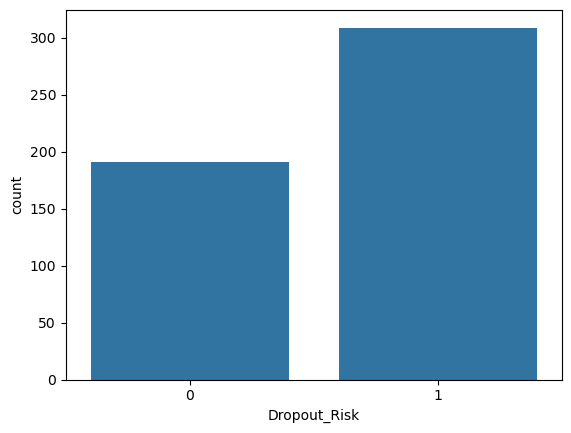

In [6]:
sns.countplot(x=df["Dropout_Risk"])
plt.show()

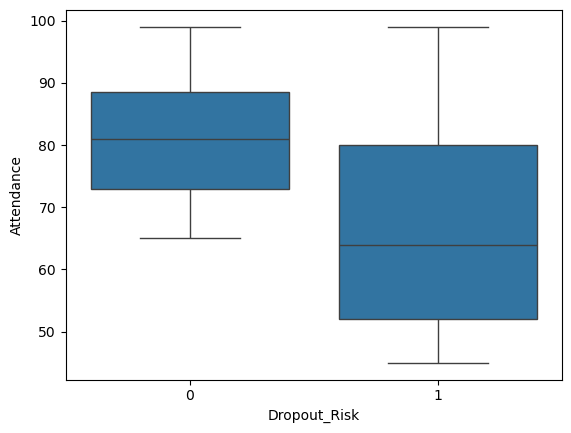

In [7]:
sns.boxplot(x=df["Dropout_Risk"], y=df["Attendance"])
plt.show()

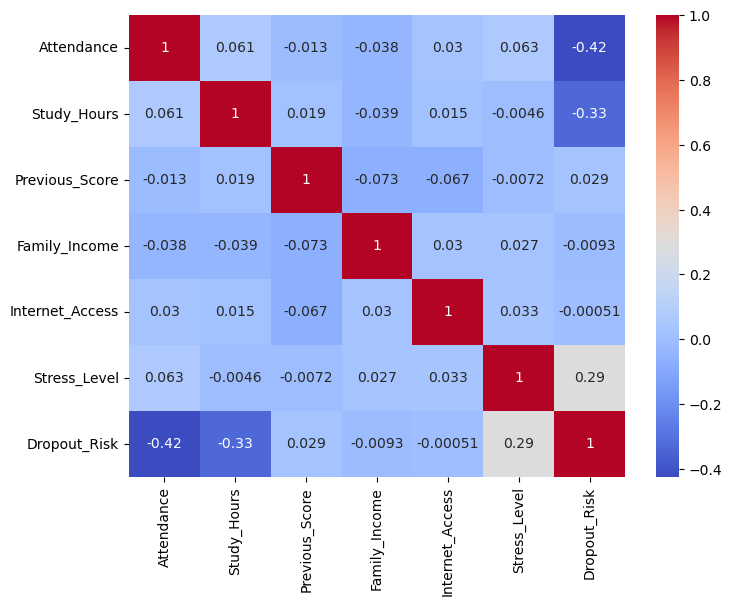

In [8]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()

In [9]:
X = df.drop("Dropout_Risk", axis=1)
y = df["Dropout_Risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [15]:
pipeline = Pipeline([("scaler", StandardScaler()),
    ("model", RandomForestClassifier(n_estimators=200,max_depth=8,class_weight="balanced",random_state=42))])


In [16]:
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",8
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2


In [19]:
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring="accuracy")

print("Cross-Validation Accuracy:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())


Cross-Validation Accuracy: [1. 1. 1. 1. 1.]
Mean Accuracy: 1.0


In [20]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        62

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



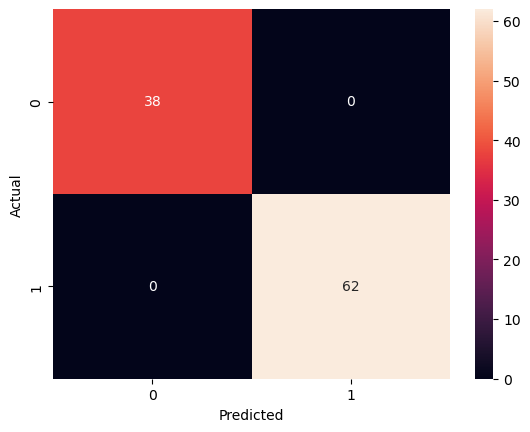

In [23]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [25]:
importances = pipeline.named_steps["model"].feature_importances_

feature_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

feature_df


,Feature,Importance
0,Attendance,0.388204
1,Study_Hours,0.277224
5,Stress_Level,0.274476
3,Family_Income,0.033033
2,Previous_Score,0.023933
4,Internet_Access,0.003131


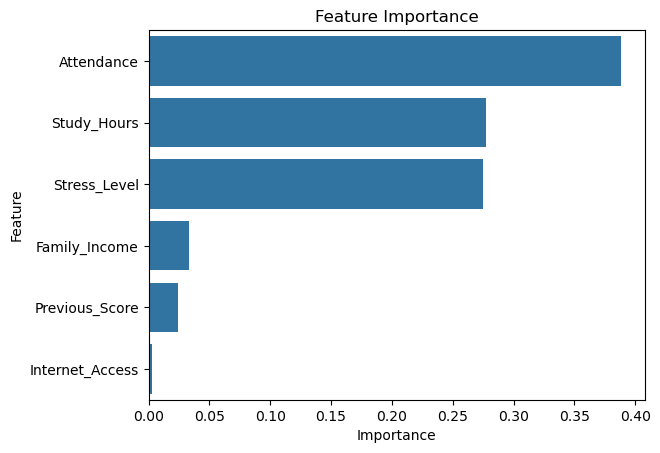

In [26]:
sns.barplot(x="Importance", y="Feature", data=feature_df)
plt.title("Feature Importance")
plt.show()


In [28]:
def predict_dropout(student_data, threshold=0.6):
    prob = pipeline.predict_proba(student_data)[0][1]
    if prob >= threshold:
        return f"High Risk ({prob*100:.2f}%)"
    else:
        return f"Low Risk ({prob*100:.2f}%)"


In [ ]:
!streamlit run app.py